In [1]:
import pandas as pd
import numpy as np
import re

# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import time

seed = 20191194

start_time = time.time()

In [2]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [3]:
df = df.dropna() # getting rid of all NULLs
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

In [4]:
#Debugging intermezzo
# df = df.sample(frac=0.1,random_state=seed)

# Building distinct data sets

In [5]:
data, outtakes = {},{}

for store in list(df.STORE_ID.unique()):
    for item in list(df.ITEM_ID.unique()):
        
        selection = df[(df.STORE_ID == store) & (df.ITEM_ID == item)]
        
        if len(selection) >= 10:
            data['df_store_{}_item_{}'.format(int(store),int(item))] = selection
        else:
            outtakes['df_store_{}_item_{}'.format(int(store),int(item))] = selection

In [6]:
len(outtakes)/len(data)

0.047876447876447875

In [7]:
def mae(model_name, trained_model, xtest, ytest, prnt = False):
    """ Returns Model Name and Mean Absolute Error."""
    yhat = trained_model.predict(xtest)
    mae = np.exp(np.mean(np.abs(yhat - ytest))) #undo log transformation for comparison
    if prnt == True:
        print('{} Performance'.format(model_name))
        print('Mean Absolute Error: {:0.4f}\n'.format(mae))
    return model_name, mae

# Engineering, Training, (Tuning), Model Selection in a Loop

In [8]:
trainings, validations, results= {},{},{}
cnt = 0

last_x_days = 7 #Note, we could also set this dynamically depending on the amount of data.

for d in data:
    cnt += 1
    
    # In some cases dates are mixed, here it gets fixed :)
    data[d] = data[d].sort_values('DATE_ID',kind='mergesort')
    
    # Creating features from historical data
    prev_rows = {}
    for num in range(1,last_x_days+1):
        prev_rows['qty_prev_{}d'.format(num)] = [data[d].QTY.values[i-num] for i in range(len(data[d]))]
        prev_rows['qty_delta_{}d'.format(num)] = [data[d].QTY.values[i] - data[d].QTY.values[i-num] for i in range(len(data[d]))]
        prev_rows['price_prev_{}d'.format(num)] = [data[d].PRICE.values[i-num] for i in range(len(data[d]))]
        prev_rows['price_delta_{}d'.format(num)] = [data[d].PRICE.values[i] - data[d].PRICE.values[i-num] for i in range(len(data[d]))]
        prev_rows['customer_prev_{}d'.format(num)] = [data[d].CUSTOMER.values[i-num] for i in range(len(data[d]))]
        prev_rows['customer_delta_{}d'.format(num)] = [data[d].CUSTOMER.values[i] - data[d].CUSTOMER.values[i-num] for i in range(len(data[d]))]
    
    # Adding new features to dataframe
    additional_features = pd.DataFrame(prev_rows)
    for key in list(additional_features.keys()):
        data[d]['{}'.format(key)]=additional_features['{}'.format(key)].values
    del additional_features, prev_rows
    
    # Removing first rows, since there is no 'real' historical data
    data[d]=data[d].drop(data[d][:last_x_days].index)
    
    features = [col for col in list(df.keys()) if (col not in list(df.keys())[:3]) & (col not in ['QTY', 'CUSTOMER'])]
    
    # Splitting data    
    df_validation = data[d][data[d].DATE_ID > data[d].DATE_ID.max()-7]
    df_training = data[d].drop(df_validation.index)
    
    trainings['df_store_{}_item_{}_old_data'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = df_training
    validations['df_store_{}_item_{}_new_data'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = df_validation
    
    X,y = shuffle(df_training, np.log(df_training.QTY), random_state = seed)
    del df_validation,df_training
    
    # Some Store-Item Combinations throw errors due to insufficient data, we can handle them later
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

        models = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=seed),
                  'RandomForestRegressor': RandomForestRegressor(random_state=seed)}

        models_trained = {}
        for model in models:
            models_trained[model+'_default'] = models[model].fit(X_train[features],y_train)
        
        # Tuning could be added here
        # CODE
        
        # Model selection based on lowest error
        performance = {}
        for model in models_trained:
            evaluation = mae(model, models_trained[model] , X_test[features], y_test)
            performance[evaluation[0]] = [evaluation[1]]

        best_model = models_trained[min(performance, key=performance.get)]
        
        results['{}'.format(d)] = [best_model,min(performance.values())[0]]
    
    except: outtakes['df_store_{}_item_{}_loop'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = data[d]
    
    print(round(cnt/len(data),4)

# Quality Check

In [9]:
len(outtakes)/len(data)

0.05019305019305019

In [10]:
maes = np.array([results[result][1] for result in results])

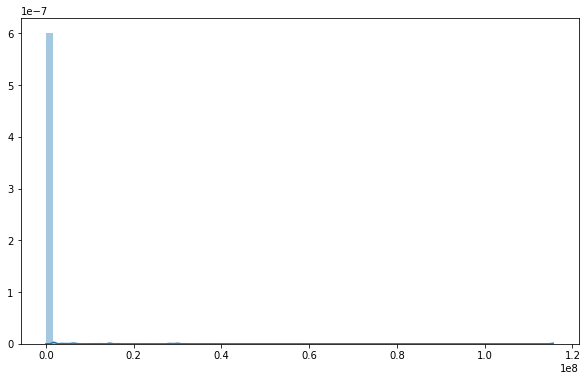

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(maes,bins=70)
plt.show()

In [12]:
len(maes[maes < 5])/len(maes)

0.8660990712074303

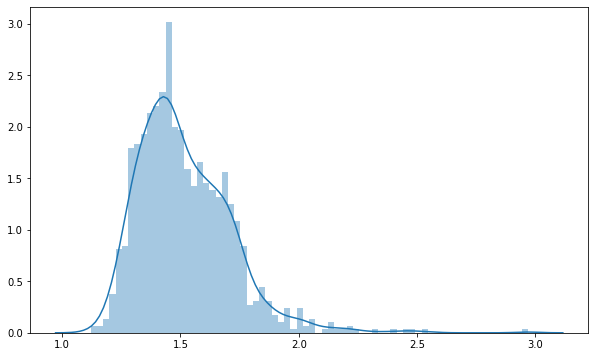

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(maes[maes < 5],bins=70)
plt.show()

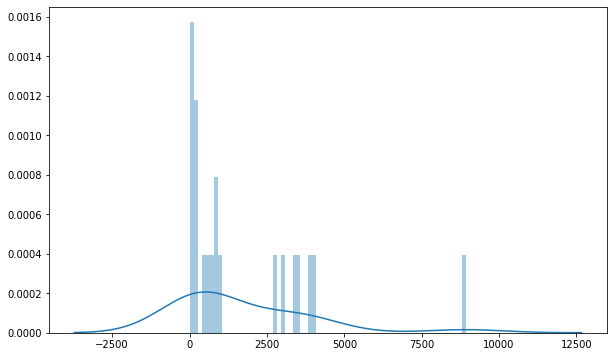

In [14]:
plt.figure(figsize=(10,6))
sns.distplot(maes[(maes > 10) & (maes < 10000)],bins=70)
plt.show()

# Predictions for next 7 days

In [15]:
# for key in results:
#     print(key,np.exp(results[key][0].predict(validations['df_store_36_item_2_new_data'][features])))
#     break

# validations['df_store_36_item_2_new_data'].QTY#.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))]


In [16]:
# mae(model, models_trained[model] , X_test[features], y_test)

In [17]:
maes_new_data = []
for result in results:
    maes_new_data.append(mae('model',results[result][0],validations[result+'_new_data'][features],\
                             np.log(validations[result+'_new_data'].QTY))[1])

In [18]:
maes_new = np.array(maes_new_data)

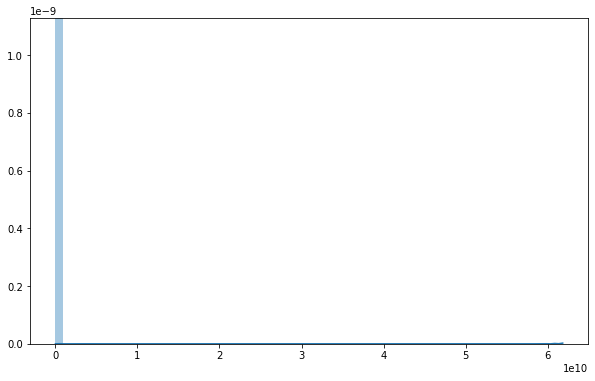

In [19]:
plt.figure(figsize=(10,6))
sns.distplot(maes_new,bins=70)
plt.show()

In [20]:
len(maes_new[maes_new < 5])/len(maes_new)

0.8660990712074303

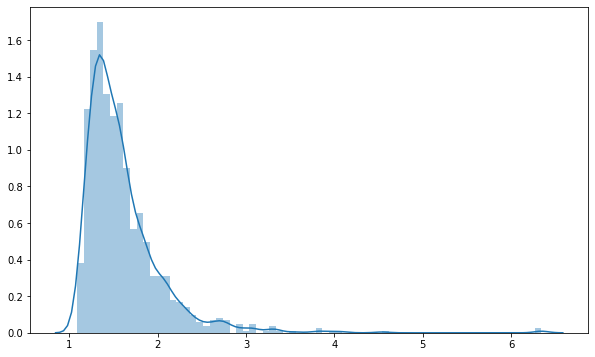

In [21]:
plt.figure(figsize=(10,6))
sns.distplot(maes_new[maes_new < 10],bins=70)
plt.show()

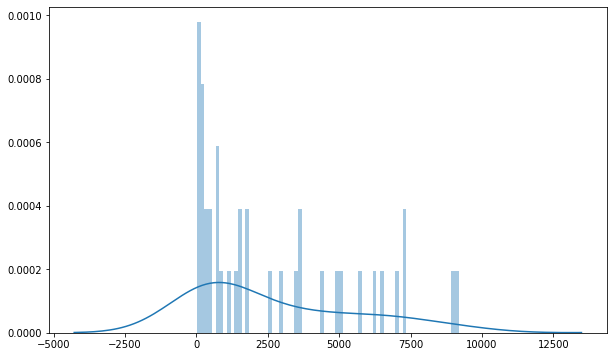

In [22]:
plt.figure(figsize=(10,6))
sns.distplot(maes_new[(maes_new > 10) & (maes_new < 10000)],bins=70)
plt.show()

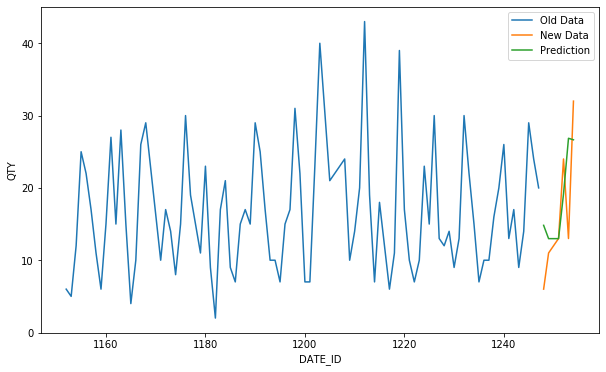

In [44]:
lookback_days = 90
plt.figure(figsize=(10,6))
startfrom = 1000

store_item_combo='df_store_17_item_12'
olddata = trainings[store_item_combo+'_old_data']
newdata = validations[store_item_combo+'_new_data']

sns.lineplot(olddata[olddata.DATE_ID>startfrom].DATE_ID[-lookback_days:],olddata.QTY[-lookback_days:], label = "Old Data")
sns.lineplot(newdata.DATE_ID,newdata.QTY, label = "New Data")
sns.lineplot(newdata.DATE_ID,np.exp(results[store_item_combo][0].predict(newdata[features])), label = "Prediction")
plt.show()

In [24]:
elapsed_time = time.time() - start_time
elapsed_time

# for dataframe in trainings:
#     print(dataframe)
#     break

# results['df_store_29_item_3'][0]

# trainings['df_store_3_item_4_old_data'].head()
# validations['df_store_29_item_3_new_data'].head()
# for i in validations:
#     print(i,len(validations[i]))

416.98443603515625

In [39]:
416.98443603515625/60

6.949740600585938

In [40]:
0.8660990712074303==0.8660990712074303

True